# Grid Multi-Object Image Generation
**Author:** G8  
**Task:** 1.2 - Generate Grid-Based Multi-Object Images with YOLO Annotations  
**Timeline:** Feb 2025  

**Purpose:**
- Generate multi-object images using all grid layouts (m×n where m,n ∈ {1, ..., MAX_GRID_SIZE})
- Create YOLO format annotations
- Split into train/val/test for YOLOv8 training
- Generate oversize test images for model robustness testing

## Setup and Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration

In [2]:
# =============================================================================
# CONFIGURATION - MODIFY THESE PARAMETERS AS NEEDED
# =============================================================================

# Maximum grid dimension (generates all m×n where m,n ∈ {1, ..., MAX_GRID_SIZE})
MAX_GRID_SIZE = 8

# Number of images per grid configuration
# Adjust based on grid complexity
IMAGES_PER_GRID = {
    'small': 100,    # For grids with 1-4 objects (1x1, 1x2, 2x1, 2x2)
    'medium': 150,   # For grids with 5-9 objects (2x3, 3x2, 3x3, etc.)
    'large': 200,    # For grids with 10+ objects (3x4, 4x3, 4x4, etc.)
    'extreme': 200,  # For extreme aspect ratios (1x5, 5x1, ...)
}

# Cell size for each object
CELL_SIZE = 224

# Train/Val/Test split ratios
SPLIT_RATIOS = {'train': 0.70, 'val': 0.15, 'test': 0.15}

# =============================================================================
# PATHS
# =============================================================================
PROJECT_ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
PROCESSED_PATH = PROJECT_ROOT / "data" / "processed" / "single_objects" / "train"
OUTPUT_BASE = PROJECT_ROOT / "data" / "multi_objects_grid"
OUTPUT_IMAGES = OUTPUT_BASE / "images"
OUTPUT_LABELS = OUTPUT_BASE / "labels"
OVERSIZE_PATH = PROJECT_ROOT / "data" / "multi_objects_grid" / "oversize"
STATS_PATH = PROJECT_ROOT / "data" / "statistics"

# Create directories
for path in [OUTPUT_IMAGES, OUTPUT_LABELS, OVERSIZE_PATH, STATS_PATH]:
    path.mkdir(parents=True, exist_ok=True)

# Load class mapping
with open(PROJECT_ROOT / "data" / "class_mapping.json", 'r') as f:
    class_mapping = json.load(f)

print("Configuration:")
print(f"  MAX_GRID_SIZE: {MAX_GRID_SIZE}")
print(f"  Total grid types: {MAX_GRID_SIZE * MAX_GRID_SIZE}")
print(f"  Cell size: {CELL_SIZE}×{CELL_SIZE}")
print(f"  Total classes: {class_mapping['num_classes']}")
print(f"  Output path: {OUTPUT_BASE}")

Configuration:
  MAX_GRID_SIZE: 8
  Total grid types: 64
  Cell size: 224×224
  Total classes: 39
  Output path: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/data/multi_objects_grid


## Generate Grid Configurations

In [3]:
def get_grid_category(rows, cols):
    """
    Determine category based on grid complexity
    """
    num_objects = rows * cols
    aspect_ratio = max(rows, cols) / min(rows, cols) if min(rows, cols) > 0 else 1
    
    # Extreme aspect ratios (1xN or Nx1 where N >= 4)
    if (rows == 1 or cols == 1) and max(rows, cols) >= 4:
        return 'extreme'
    # Small grids (1-4 objects)
    elif num_objects <= 4:
        return 'small'
    # Medium grids (5-9 objects)
    elif num_objects <= 9:
        return 'medium'
    # Large grids (10+ objects)
    else:
        return 'large'


def generate_grid_configs(max_size):
    """
    Generate all grid configurations from 1×1 to max_size×max_size
    """
    configs = []
    
    for m in range(1, max_size + 1):
        for n in range(1, max_size + 1):
            category = get_grid_category(m, n)
            count = IMAGES_PER_GRID[category]
            
            configs.append({
                'name': f'{m}x{n}',
                'rows': m,
                'cols': n,
                'objects': m * n,
                'category': category,
                'count': count,
                'aspect_ratio': f"{m}:{n}",
                'image_size': f"{m * CELL_SIZE}×{n * CELL_SIZE}"
            })
    
    return configs


# Generate configurations
GRID_CONFIGS = generate_grid_configs(MAX_GRID_SIZE)

# Display summary
print("="*80)
print("GRID CONFIGURATIONS SUMMARY")
print("="*80)

df_configs = pd.DataFrame(GRID_CONFIGS)
print(f"\nTotal configurations: {len(GRID_CONFIGS)}")
print(f"\nBy category:")
for cat in ['small', 'medium', 'large', 'extreme']:
    cat_configs = [c for c in GRID_CONFIGS if c['category'] == cat]
    total_imgs = sum(c['count'] for c in cat_configs)
    print(f"  {cat.capitalize()}: {len(cat_configs)} configs, {total_imgs} images")

total_images = sum(c['count'] for c in GRID_CONFIGS)
print(f"\nTotal images to generate: {total_images}")

# Show sample configurations
print("\nSample configurations:")
print(df_configs[['name', 'objects', 'category', 'count', 'image_size']].head(10).to_string(index=False))

GRID CONFIGURATIONS SUMMARY

Total configurations: 64

By category:
  Small: 6 configs, 600 images
  Medium: 5 configs, 750 images
  Large: 43 configs, 8600 images
  Extreme: 10 configs, 2000 images

Total images to generate: 11950

Sample configurations:
name  objects category  count image_size
 1x1        1    small    100    224×224
 1x2        2    small    100    224×448
 1x3        3    small    100    224×672
 1x4        4  extreme    200    224×896
 1x5        5  extreme    200   224×1120
 1x6        6  extreme    200   224×1344
 1x7        7  extreme    200   224×1568
 1x8        8  extreme    200   224×1792
 2x1        2    small    100    448×224
 2x2        4    small    100    448×448


## Load Processed Images

In [4]:
def load_image_paths():
    """
    Load all preprocessed image paths organized by class
    """
    print("="*80)
    print("LOADING PROCESSED IMAGES")
    print("="*80)
    
    image_dict = {}
    
    for obj_folder in PROCESSED_PATH.iterdir():
        if obj_folder.is_dir():
            obj_id = obj_folder.name
            images = sorted(list(obj_folder.glob("*.jpg")))
            if len(images) > 0:
                image_dict[obj_id] = images
    
    total_images = sum(len(imgs) for imgs in image_dict.values())
    
    print(f"\nLoaded {len(image_dict)} object classes")
    print(f"Total images available: {total_images}")
    print(f"Average images per class: {total_images / len(image_dict):.1f}")
    
    return image_dict


image_paths = load_image_paths()

LOADING PROCESSED IMAGES

Loaded 39 object classes
Total images available: 2943
Average images per class: 75.5


## Grid Image Generation Functions

In [5]:
def create_grid_image(image_paths_dict, class_mapping, rows, cols, cell_size=CELL_SIZE):
    """
    Create a grid image with multiple objects
    
    Args:
        image_paths_dict: Dict of {obj_id: [image_paths]}
        class_mapping: Class to index mapping
        rows: Number of rows in grid
        cols: Number of columns in grid
        cell_size: Size of each cell (default: 224)
    
    Returns:
        grid_image: Combined image (rows*cell_size × cols*cell_size)
        annotations: List of YOLO format annotations
        object_ids: List of object IDs used
    """
    num_objects = rows * cols
    
    # Select object classes (with replacement if needed)
    available_classes = list(image_paths_dict.keys())
    if num_objects <= len(available_classes):
        selected_classes = random.sample(available_classes, num_objects)
    else:
        selected_classes = random.choices(available_classes, k=num_objects)
    
    # Create blank grid
    grid_height = rows * cell_size
    grid_width = cols * cell_size
    grid_image = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)
    
    annotations = []
    object_ids = []
    
    # Fill grid with objects
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            obj_id = selected_classes[idx]
            object_ids.append(obj_id)
            
            # Load and resize image
            img_path = random.choice(image_paths_dict[obj_id])
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if img.shape[0] != cell_size or img.shape[1] != cell_size:
                img = cv2.resize(img, (cell_size, cell_size))
            
            # Place in grid
            y_start = i * cell_size
            y_end = y_start + cell_size
            x_start = j * cell_size
            x_end = x_start + cell_size
            grid_image[y_start:y_end, x_start:x_end] = img
            
            # Create YOLO annotation (normalized coordinates)
            class_idx = class_mapping['class_to_idx'][obj_id]
            x_center = (x_start + cell_size / 2) / grid_width
            y_center = (y_start + cell_size / 2) / grid_height
            box_width = cell_size / grid_width
            box_height = cell_size / grid_height
            
            annotations.append(f"{class_idx} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")
    
    return grid_image, annotations, object_ids


# Test the function
print("Testing grid generation...")
for config in [{'rows': 1, 'cols': 1}, {'rows': 2, 'cols': 3}, {'rows': 5, 'cols': 5}]:
    test_grid, test_annot, test_ids = create_grid_image(
        image_paths, class_mapping, config['rows'], config['cols']
    )
    print(f"  {config['rows']}×{config['cols']}: shape={test_grid.shape}, objects={len(test_annot)}")

Testing grid generation...
  1×1: shape=(224, 224, 3), objects=1
  2×3: shape=(448, 672, 3), objects=6
  5×5: shape=(1120, 1120, 3), objects=25


## Generate All Grid Images

In [6]:
print("="*80)
print("GENERATING GRID IMAGES")
print("="*80)

# Create temporary folder for all generated images
temp_images = OUTPUT_IMAGES / "all_generated"
temp_labels = OUTPUT_LABELS / "all_generated"
temp_images.mkdir(parents=True, exist_ok=True)
temp_labels.mkdir(parents=True, exist_ok=True)

generation_stats = []
image_counter = 0

# Generate for each configuration
for config in GRID_CONFIGS:
    grid_name = config['name']
    rows = config['rows']
    cols = config['cols']
    count = config['count']
    
    print(f"\nGenerating {count} images for {grid_name} grid ({rows}×{cols}, {config['objects']} objects)...")
    
    for i in tqdm(range(count), desc=f"{grid_name}"):
        # Generate image
        grid_img, annotations, _ = create_grid_image(
            image_paths, class_mapping, rows, cols
        )
        
        # Save image
        img_filename = f"grid_{grid_name}_{image_counter:05d}.jpg"
        img_path = temp_images / img_filename
        cv2.imwrite(str(img_path), cv2.cvtColor(grid_img, cv2.COLOR_RGB2BGR))
        
        # Save annotation
        label_filename = f"grid_{grid_name}_{image_counter:05d}.txt"
        label_path = temp_labels / label_filename
        with open(label_path, 'w') as f:
            f.write('\n'.join(annotations))
        
        image_counter += 1
    
    generation_stats.append({
        'grid': grid_name,
        'rows': rows,
        'cols': cols,
        'objects': config['objects'],
        'category': config['category'],
        'images': count
    })

print(f"\n" + "="*80)
print(f"GENERATION COMPLETE: {image_counter} images")
print("="*80)

GENERATING GRID IMAGES

Generating 100 images for 1x1 grid (1×1, 1 objects)...


1x1: 100%|██████████| 100/100 [00:00<00:00, 772.11it/s]



Generating 100 images for 1x2 grid (1×2, 2 objects)...


1x2: 100%|██████████| 100/100 [00:00<00:00, 510.00it/s]



Generating 100 images for 1x3 grid (1×3, 3 objects)...


1x3: 100%|██████████| 100/100 [00:00<00:00, 407.39it/s]



Generating 200 images for 1x4 grid (1×4, 4 objects)...


1x4: 100%|██████████| 200/200 [00:00<00:00, 327.63it/s]



Generating 200 images for 1x5 grid (1×5, 5 objects)...


1x5: 100%|██████████| 200/200 [00:00<00:00, 300.98it/s]



Generating 200 images for 1x6 grid (1×6, 6 objects)...


1x6: 100%|██████████| 200/200 [00:00<00:00, 263.07it/s]



Generating 200 images for 1x7 grid (1×7, 7 objects)...


1x7: 100%|██████████| 200/200 [00:00<00:00, 244.99it/s]



Generating 200 images for 1x8 grid (1×8, 8 objects)...


1x8: 100%|██████████| 200/200 [00:00<00:00, 236.08it/s]



Generating 100 images for 2x1 grid (2×1, 2 objects)...


2x1: 100%|██████████| 100/100 [00:00<00:00, 826.25it/s]



Generating 100 images for 2x2 grid (2×2, 4 objects)...


2x2: 100%|██████████| 100/100 [00:00<00:00, 457.75it/s]



Generating 150 images for 2x3 grid (2×3, 6 objects)...


2x3: 100%|██████████| 150/150 [00:00<00:00, 295.86it/s]



Generating 150 images for 2x4 grid (2×4, 8 objects)...


2x4: 100%|██████████| 150/150 [00:00<00:00, 207.70it/s]



Generating 200 images for 2x5 grid (2×5, 10 objects)...


2x5: 100%|██████████| 200/200 [00:01<00:00, 190.40it/s]



Generating 200 images for 2x6 grid (2×6, 12 objects)...


2x6: 100%|██████████| 200/200 [00:01<00:00, 152.85it/s]



Generating 200 images for 2x7 grid (2×7, 14 objects)...


2x7: 100%|██████████| 200/200 [00:01<00:00, 139.89it/s]



Generating 200 images for 2x8 grid (2×8, 16 objects)...


2x8: 100%|██████████| 200/200 [00:01<00:00, 124.48it/s]



Generating 100 images for 3x1 grid (3×1, 3 objects)...


3x1: 100%|██████████| 100/100 [00:00<00:00, 616.80it/s]



Generating 150 images for 3x2 grid (3×2, 6 objects)...


3x2: 100%|██████████| 150/150 [00:00<00:00, 298.39it/s]



Generating 150 images for 3x3 grid (3×3, 9 objects)...


3x3: 100%|██████████| 150/150 [00:00<00:00, 225.45it/s]



Generating 200 images for 3x4 grid (3×4, 12 objects)...


3x4: 100%|██████████| 200/200 [00:01<00:00, 155.85it/s]



Generating 200 images for 3x5 grid (3×5, 15 objects)...


3x5: 100%|██████████| 200/200 [00:02<00:00, 92.85it/s] 



Generating 200 images for 3x6 grid (3×6, 18 objects)...


3x6: 100%|██████████| 200/200 [00:01<00:00, 110.50it/s]



Generating 200 images for 3x7 grid (3×7, 21 objects)...


3x7: 100%|██████████| 200/200 [00:02<00:00, 92.92it/s]



Generating 200 images for 3x8 grid (3×8, 24 objects)...


3x8: 100%|██████████| 200/200 [00:02<00:00, 75.05it/s]



Generating 200 images for 4x1 grid (4×1, 4 objects)...


4x1: 100%|██████████| 200/200 [00:00<00:00, 413.53it/s]



Generating 150 images for 4x2 grid (4×2, 8 objects)...


4x2: 100%|██████████| 150/150 [00:00<00:00, 240.79it/s]



Generating 200 images for 4x3 grid (4×3, 12 objects)...


4x3: 100%|██████████| 200/200 [00:01<00:00, 160.93it/s]



Generating 200 images for 4x4 grid (4×4, 16 objects)...


4x4: 100%|██████████| 200/200 [00:01<00:00, 107.40it/s]



Generating 200 images for 4x5 grid (4×5, 20 objects)...


4x5: 100%|██████████| 200/200 [00:02<00:00, 99.17it/s] 



Generating 200 images for 4x6 grid (4×6, 24 objects)...


4x6: 100%|██████████| 200/200 [00:02<00:00, 83.95it/s]



Generating 200 images for 4x7 grid (4×7, 28 objects)...


4x7: 100%|██████████| 200/200 [00:03<00:00, 62.42it/s]



Generating 200 images for 4x8 grid (4×8, 32 objects)...


4x8: 100%|██████████| 200/200 [00:03<00:00, 63.49it/s]



Generating 200 images for 5x1 grid (5×1, 5 objects)...


5x1: 100%|██████████| 200/200 [00:00<00:00, 283.80it/s]



Generating 200 images for 5x2 grid (5×2, 10 objects)...


5x2: 100%|██████████| 200/200 [00:01<00:00, 195.96it/s]



Generating 200 images for 5x3 grid (5×3, 15 objects)...


5x3: 100%|██████████| 200/200 [00:01<00:00, 124.95it/s]



Generating 200 images for 5x4 grid (5×4, 20 objects)...


5x4: 100%|██████████| 200/200 [00:02<00:00, 93.30it/s]



Generating 200 images for 5x5 grid (5×5, 25 objects)...


5x5: 100%|██████████| 200/200 [00:02<00:00, 77.11it/s]



Generating 200 images for 5x6 grid (5×6, 30 objects)...


5x6: 100%|██████████| 200/200 [00:02<00:00, 68.06it/s]



Generating 200 images for 5x7 grid (5×7, 35 objects)...


5x7: 100%|██████████| 200/200 [00:03<00:00, 52.09it/s]



Generating 200 images for 5x8 grid (5×8, 40 objects)...


5x8: 100%|██████████| 200/200 [00:03<00:00, 51.11it/s]



Generating 200 images for 6x1 grid (6×1, 6 objects)...


6x1: 100%|██████████| 200/200 [00:00<00:00, 270.98it/s]



Generating 200 images for 6x2 grid (6×2, 12 objects)...


6x2: 100%|██████████| 200/200 [00:01<00:00, 142.24it/s]



Generating 200 images for 6x3 grid (6×3, 18 objects)...


6x3: 100%|██████████| 200/200 [00:02<00:00, 99.62it/s] 



Generating 200 images for 6x4 grid (6×4, 24 objects)...


6x4: 100%|██████████| 200/200 [00:02<00:00, 73.29it/s]



Generating 200 images for 6x5 grid (6×5, 30 objects)...


6x5: 100%|██████████| 200/200 [00:03<00:00, 62.20it/s]



Generating 200 images for 6x6 grid (6×6, 36 objects)...


6x6: 100%|██████████| 200/200 [00:04<00:00, 43.25it/s]



Generating 200 images for 6x7 grid (6×7, 42 objects)...


6x7: 100%|██████████| 200/200 [00:04<00:00, 45.21it/s]



Generating 200 images for 6x8 grid (6×8, 48 objects)...


6x8: 100%|██████████| 200/200 [00:05<00:00, 37.77it/s]



Generating 200 images for 7x1 grid (7×1, 7 objects)...


7x1: 100%|██████████| 200/200 [00:00<00:00, 226.35it/s]



Generating 200 images for 7x2 grid (7×2, 14 objects)...


7x2: 100%|██████████| 200/200 [00:01<00:00, 128.45it/s]



Generating 200 images for 7x3 grid (7×3, 21 objects)...


7x3: 100%|██████████| 200/200 [00:02<00:00, 78.75it/s]



Generating 200 images for 7x4 grid (7×4, 28 objects)...


7x4: 100%|██████████| 200/200 [00:02<00:00, 72.07it/s]



Generating 200 images for 7x5 grid (7×5, 35 objects)...


7x5: 100%|██████████| 200/200 [00:03<00:00, 56.96it/s]



Generating 200 images for 7x6 grid (7×6, 42 objects)...


7x6: 100%|██████████| 200/200 [00:04<00:00, 46.66it/s]



Generating 200 images for 7x7 grid (7×7, 49 objects)...


7x7: 100%|██████████| 200/200 [00:04<00:00, 40.71it/s]



Generating 200 images for 7x8 grid (7×8, 56 objects)...


7x8: 100%|██████████| 200/200 [00:05<00:00, 35.57it/s]



Generating 200 images for 8x1 grid (8×1, 8 objects)...


8x1: 100%|██████████| 200/200 [00:00<00:00, 235.76it/s]



Generating 200 images for 8x2 grid (8×2, 16 objects)...


8x2: 100%|██████████| 200/200 [00:01<00:00, 120.08it/s]



Generating 200 images for 8x3 grid (8×3, 24 objects)...


8x3: 100%|██████████| 200/200 [00:02<00:00, 80.77it/s]



Generating 200 images for 8x4 grid (8×4, 32 objects)...


8x4: 100%|██████████| 200/200 [00:03<00:00, 60.52it/s]



Generating 200 images for 8x5 grid (8×5, 40 objects)...


8x5: 100%|██████████| 200/200 [00:04<00:00, 48.47it/s]



Generating 200 images for 8x6 grid (8×6, 48 objects)...


8x6: 100%|██████████| 200/200 [00:04<00:00, 41.58it/s]



Generating 200 images for 8x7 grid (8×7, 56 objects)...


8x7: 100%|██████████| 200/200 [00:05<00:00, 37.79it/s]



Generating 200 images for 8x8 grid (8×8, 64 objects)...


8x8: 100%|██████████| 200/200 [00:05<00:00, 33.96it/s]


GENERATION COMPLETE: 11950 images


## Generate Oversize Test Images

In [7]:
print("="*80)
print("GENERATING OVERSIZE TEST IMAGES")
print("="*80)

OVERSIZE_GRID = MAX_GRID_SIZE + 2  # e.g., if MAX_GRID_SIZE=5, generate 7x7
NUM_OVERSIZE = 10

print(f"\nGenerating {NUM_OVERSIZE} oversize images ({OVERSIZE_GRID}×{OVERSIZE_GRID} grid)")
print(f"Image size: {OVERSIZE_GRID * CELL_SIZE}×{OVERSIZE_GRID * CELL_SIZE} pixels")
print(f"Objects per image: {OVERSIZE_GRID * OVERSIZE_GRID}")

oversize_images_path = OVERSIZE_PATH / "images"
oversize_labels_path = OVERSIZE_PATH / "labels"
oversize_images_path.mkdir(parents=True, exist_ok=True)
oversize_labels_path.mkdir(parents=True, exist_ok=True)

for i in tqdm(range(NUM_OVERSIZE), desc="Oversize images"):
    # Generate oversize grid
    grid_img, annotations, object_ids = create_grid_image(
        image_paths, class_mapping, OVERSIZE_GRID, OVERSIZE_GRID
    )
    
    # Save image
    img_filename = f"oversize_{OVERSIZE_GRID}x{OVERSIZE_GRID}_{i:03d}.jpg"
    cv2.imwrite(str(oversize_images_path / img_filename), 
                cv2.cvtColor(grid_img, cv2.COLOR_RGB2BGR))
    
    # Save annotation
    label_filename = f"oversize_{OVERSIZE_GRID}x{OVERSIZE_GRID}_{i:03d}.txt"
    with open(oversize_labels_path / label_filename, 'w') as f:
        f.write('\n'.join(annotations))

print(f"\nOversize images saved to: {OVERSIZE_PATH}")
print(f"  - Images: {oversize_images_path}")
print(f"  - Labels: {oversize_labels_path}")

GENERATING OVERSIZE TEST IMAGES

Generating 10 oversize images (10×10 grid)
Image size: 2240×2240 pixels
Objects per image: 100


Oversize images: 100%|██████████| 10/10 [00:00<00:00, 21.64it/s]


Oversize images saved to: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/data/multi_objects_grid/oversize
  - Images: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/data/multi_objects_grid/oversize/images
  - Labels: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/data/multi_objects_grid/oversize/labels


## Split Dataset

In [8]:
print("="*80)
print("SPLITTING DATASET")
print("="*80)

# Get all generated images
all_images = sorted(list(temp_images.glob("*.jpg")))
all_labels = sorted(list(temp_labels.glob("*.txt")))

print(f"\nTotal images: {len(all_images)}")
print(f"Total labels: {len(all_labels)}")

# Shuffle
combined = list(zip(all_images, all_labels))
random.shuffle(combined)

# Calculate split indices
n = len(combined)
train_end = int(n * SPLIT_RATIOS['train'])
val_end = train_end + int(n * SPLIT_RATIOS['val'])

splits = {
    'train': combined[:train_end],
    'val': combined[train_end:val_end],
    'test': combined[val_end:]
}

# Copy to split folders
for split_name, data in splits.items():
    img_folder = OUTPUT_IMAGES / split_name
    label_folder = OUTPUT_LABELS / split_name
    img_folder.mkdir(parents=True, exist_ok=True)
    label_folder.mkdir(parents=True, exist_ok=True)
    
    print(f"\nCopying {len(data)} images to {split_name}...")
    
    for img_path, label_path in tqdm(data, desc=split_name):
        shutil.copy2(img_path, img_folder / img_path.name)
        shutil.copy2(label_path, label_folder / label_path.name)

print("\n" + "="*80)
print("SPLIT COMPLETE")
print("="*80)
for split_name, data in splits.items():
    print(f"  {split_name.capitalize()}: {len(data)} ({len(data)/n*100:.1f}%)")

SPLITTING DATASET

Total images: 15400
Total labels: 15400

Copying 10780 images to train...


train: 100%|██████████| 10780/10780 [00:13<00:00, 783.41it/s]



Copying 2310 images to val...


val: 100%|██████████| 2310/2310 [00:03<00:00, 628.82it/s]



Copying 2310 images to test...


test: 100%|██████████| 2310/2310 [00:03<00:00, 605.21it/s]


SPLIT COMPLETE
  Train: 10780 (70.0%)
  Val: 2310 (15.0%)
  Test: 2310 (15.0%)


## Create data.yaml for YOLOv8

In [9]:
print("="*80)
print("CREATING data_grid.yaml")
print("="*80)

data_yaml_path = PROJECT_ROOT / "data" / "data_grid.yaml"

yaml_content = f"""# YOLOv8 Grid Dataset Configuration
# Generated for CNN Attendance System Project
# Contains all grid configurations (m×n where m,n ∈ {{1,...,{MAX_GRID_SIZE}}})

path: {OUTPUT_BASE.absolute()}
train: images/train
val: images/val
test: images/test

# Number of classes
nc: {class_mapping['num_classes']}

# Class names
names:
"""

# Add class names
idx_to_class = class_mapping['idx_to_class']
for idx in range(class_mapping['num_classes']):
    class_name = idx_to_class[str(idx)]
    yaml_content += f"  {idx}: {class_name}\n"

# Save
with open(data_yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"\nSaved: {data_yaml_path}")
print(f"Classes: {class_mapping['num_classes']}")

CREATING data_grid.yaml

Saved: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/data/data_grid.yaml
Classes: 39


## Visualize Samples

VISUALIZING SAMPLES


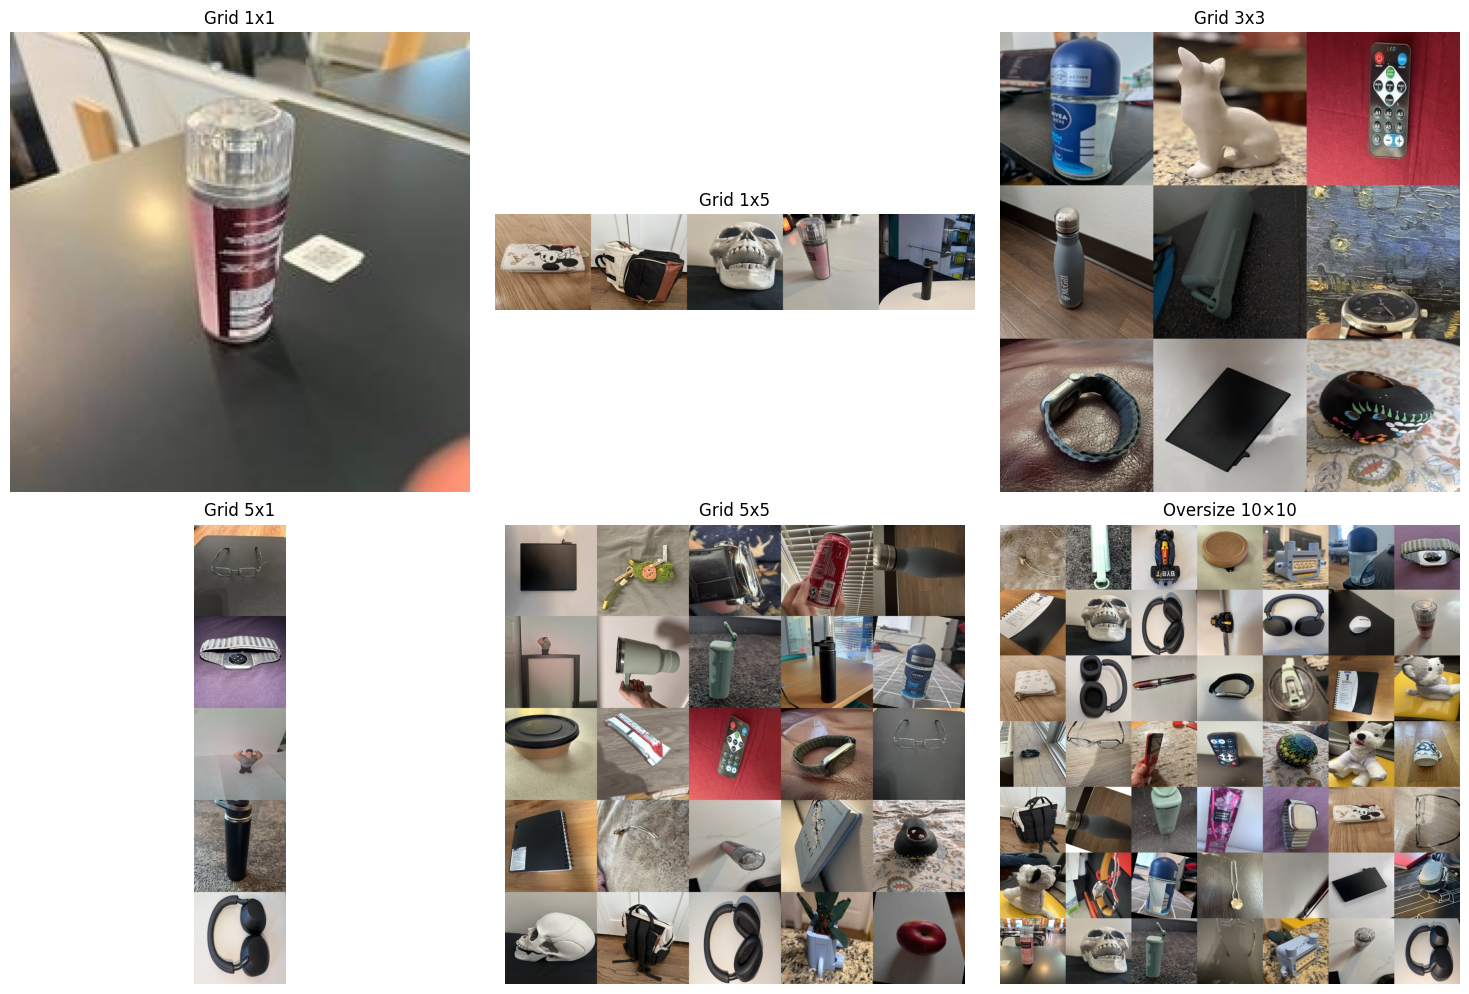


Samples saved to statistics folder


In [10]:
def visualize_grid_sample(image_path, label_path, class_mapping, title=""):
    """
    Visualize a grid image with bounding boxes
    """
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img)
    
    idx_to_class = class_mapping['idx_to_class']
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    
    for line in lines:
        parts = line.strip().split()
        class_idx = int(parts[0])
        x_center = float(parts[1]) * w
        y_center = float(parts[2]) * h
        box_w = float(parts[3]) * w
        box_h = float(parts[4]) * h
        
        x1 = x_center - box_w / 2
        y1 = y_center - box_h / 2
        
        color = colors[class_idx % 20]
        rect = patches.Rectangle((x1, y1), box_w, box_h,
                                  linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        class_name = idx_to_class[str(class_idx)]
        ax.text(x1, y1 - 5, class_name, color='white', fontsize=7,
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
    
    ax.axis('off')
    ax.set_title(f"{title} ({len(lines)} objects)")
    plt.tight_layout()
    return fig


print("="*80)
print("VISUALIZING SAMPLES")
print("="*80)

# Select representative grids to visualize
sample_grids = ['1x1', '1x5', '3x3', '5x1', '5x5']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, grid_name in enumerate(sample_grids):
    # Find sample image
    sample_imgs = list((OUTPUT_IMAGES / "train").glob(f"grid_{grid_name}_*.jpg"))
    if sample_imgs:
        img_path = sample_imgs[0]
        label_path = OUTPUT_LABELS / "train" / f"{img_path.stem}.txt"
        
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img)
        axes[idx].set_title(f"Grid {grid_name}")
        axes[idx].axis('off')

# Show oversize sample
oversize_imgs = list((oversize_images_path).glob("*.jpg"))
if oversize_imgs:
    img = cv2.imread(str(oversize_imgs[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[5].imshow(img)
    axes[5].set_title(f"Oversize {OVERSIZE_GRID}×{OVERSIZE_GRID}")
    axes[5].axis('off')

plt.tight_layout()
plt.savefig(STATS_PATH / "grid_samples_overview.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nSamples saved to statistics folder")

## Generate Statistics Report

In [11]:
print("="*80)
print("GENERATION STATISTICS")
print("="*80)

# Generation stats
df_stats = pd.DataFrame(generation_stats)
print("\nGeneration by grid type:")
print(df_stats.to_string(index=False))

# Save stats
df_stats.to_csv(STATS_PATH / "grid_generation_stats.csv", index=False)

# Final split summary
split_summary = {
    'split': ['train', 'val', 'test', 'oversize'],
    'images': [
        len(list((OUTPUT_IMAGES / 'train').glob('*.jpg'))),
        len(list((OUTPUT_IMAGES / 'val').glob('*.jpg'))),
        len(list((OUTPUT_IMAGES / 'test').glob('*.jpg'))),
        len(list(oversize_images_path.glob('*.jpg')))
    ]
}

df_split = pd.DataFrame(split_summary)
df_split['percentage'] = df_split['images'] / df_split['images'].sum() * 100

print("\nFinal dataset distribution:")
print(df_split.to_string(index=False))

df_split.to_csv(STATS_PATH / "grid_split_distribution.csv", index=False)

GENERATION STATISTICS

Generation by grid type:
grid  rows  cols  objects category  images
 1x1     1     1        1    small     100
 1x2     1     2        2    small     100
 1x3     1     3        3    small     100
 1x4     1     4        4  extreme     200
 1x5     1     5        5  extreme     200
 1x6     1     6        6  extreme     200
 1x7     1     7        7  extreme     200
 1x8     1     8        8  extreme     200
 2x1     2     1        2    small     100
 2x2     2     2        4    small     100
 2x3     2     3        6   medium     150
 2x4     2     4        8   medium     150
 2x5     2     5       10    large     200
 2x6     2     6       12    large     200
 2x7     2     7       14    large     200
 2x8     2     8       16    large     200
 3x1     3     1        3    small     100
 3x2     3     2        6   medium     150
 3x3     3     3        9   medium     150
 3x4     3     4       12    large     200
 3x5     3     5       15    large     200
 3x6  

## Summary

In [12]:
print("="*80)
print("GRID MULTI-OBJECT GENERATION COMPLETE")
print("="*80)

print("\nOutput Structure:")
print(f"  {OUTPUT_BASE}/")
print(f"  ├── images/")
print(f"  │   ├── train/  ({len(list((OUTPUT_IMAGES / 'train').glob('*.jpg')))} images)")
print(f"  │   ├── val/    ({len(list((OUTPUT_IMAGES / 'val').glob('*.jpg')))} images)")
print(f"  │   └── test/   ({len(list((OUTPUT_IMAGES / 'test').glob('*.jpg')))} images)")
print(f"  ├── labels/")
print(f"  │   ├── train/")
print(f"  │   ├── val/")
print(f"  │   └── test/")
print(f"  └── oversize/  ({len(list(oversize_images_path.glob('*.jpg')))} images, {OVERSIZE_GRID}×{OVERSIZE_GRID})")

print("\nCoverage:")
print(f"  Grid configurations: {len(GRID_CONFIGS)} (all m×n where m,n ∈ {{1,...,{MAX_GRID_SIZE}}})")
print(f"  Aspect ratios: 1:{MAX_GRID_SIZE} to {MAX_GRID_SIZE}:1")
print(f"  Objects per image: 1 to {MAX_GRID_SIZE * MAX_GRID_SIZE}")
print(f"  Oversize test: {OVERSIZE_GRID}×{OVERSIZE_GRID} ({OVERSIZE_GRID * OVERSIZE_GRID} objects)")

print(f"\nYOLO config: {PROJECT_ROOT / 'data' / 'data_grid.yaml'}")
print("\nNext step: Run 05_train_yolo_grid.ipynb")

GRID MULTI-OBJECT GENERATION COMPLETE

Output Structure:
  /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/data/multi_objects_grid/
  ├── images/
  │   ├── train/  (11681 images)
  │   ├── val/    (2833 images)
  │   └── test/   (2829 images)
  ├── labels/
  │   ├── train/
  │   ├── val/
  │   └── test/
  └── oversize/  (20 images, 10×10)

Coverage:
  Grid configurations: 64 (all m×n where m,n ∈ {1,...,8})
  Aspect ratios: 1:8 to 8:1
  Objects per image: 1 to 64
  Oversize test: 10×10 (100 objects)

YOLO config: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/data/data_grid.yaml

Next step: Run 05_train_yolo_grid.ipynb


## Cleanup (Optional)

In [13]:
# Remove temporary all_generated folder to save space
# cleanup = input("Remove temporary files? (y/n): ").strip().lower()
# if cleanup == 'y':
#     if temp_images.exists():
#         shutil.rmtree(temp_images)
#     if temp_labels.exists():
#         shutil.rmtree(temp_labels)
#     print("Temporary files removed.")
# else:
#     print("Temporary files kept.")